# Beer Recommendation
Fall 2018, 4571 Recommendation System Final Project

- Scalability: compare the performance of different algorithms among users/items with different number of reviews



## Part 1: Data Preprocessing

In [1]:
# based on Google Colab 
# python 3
!pip install scikit-surprise

In [0]:
import pandas as pd
import numpy as np
import os
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
from surprise.model_selection import train_test_split
from surprise import NMF, Reader, Dataset, SVD, NMF, accuracy

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.1 Load Data

In [0]:
# load metadata from Google Drive 
# save as a list
data = []
one_complete_review = []

with open('/content/gdrive/My Drive/beeradvocate.txt', 'r') as f:
  for i in f: 
    #row = i.decode(encoding = 'UTF-8',errors = 'ignore')
    row = i.replace('beer/', 'beer_').replace('review/','review_') 
    if row == '\n':
      data.append(one_complete_review)
      one_complete_review = []
      continue
    row = row.split(": ", 1)[1].rstrip()
    one_complete_review.append(row)

In [0]:
# convert list to dataframe
column_names = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']

df = pd.DataFrame.from_records(data, columns=column_names)

In [6]:
# descriptive 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
beer_name             1586614 non-null object
beer_beerId           1586614 non-null object
beer_brewer           1586614 non-null object
beer_ABV              1586614 non-null object
beer_style            1586614 non-null object
review_appearance     1586614 non-null object
review_aroma          1586614 non-null object
review_palate         1586614 non-null object
review_taste          1586614 non-null object
review_overall        1586614 non-null object
review_time           1586614 non-null object
review_profileName    1586614 non-null object
review_text           1586614 non-null object
dtypes: object(13)
memory usage: 157.4+ MB


In [7]:
df.head(3)

,beer_name,beer_beerId,beer_brewer,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
0,Sausa Weizen,47986,10325,5.00,Hefeweizen,2.5,2,1.5,1.5,1.5,1234817823,stcules,A lot of foam. But a lot.\tIn the smell some b...
1,Red Moon,48213,10325,6.20,English Strong Ale,3,2.5,3,3,3,1235915097,stcules,"Dark red color, light beige foam, average.\tIn..."
2,Black Horse Black Beer,48215,10325,6.50,Foreign / Export Stout,3,2.5,3,3,3,1235916604,stcules,"Almost totally black. Beige foam, quite compac..."


In [8]:
print('The full dataset includes:')
print('%d unique beers;' % df.beer_beerId.nunique())
print('%d unique users;' % df.review_profileName.nunique())
print('and %d reviews in total.' % df.shape[0])

The full dataset includes:
66055 unique beers;
33388 unique users;
and 1586614 reviews in total.


### 1.2 Exploratory Data Analysis

#### users

In [0]:
num_review_byuser = df.review_profileName.value_counts()
freq_list_user = np.array(list(dict(num_review_byuser).values()))

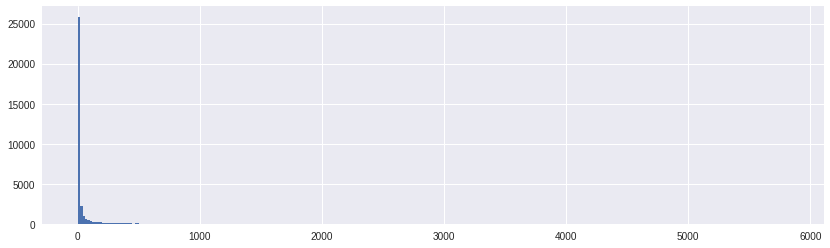

In [10]:
plt.figure(figsize=(14, 4))
plt.hist(freq_list_user, bins=300)
plt.show()

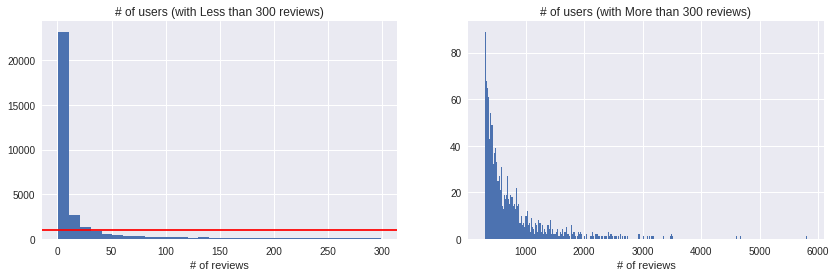

In [11]:
user5more = freq_list_user[np.where(freq_list_user >= 300)]
user5less = freq_list_user[np.where(freq_list_user < 300)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(user5less, bins=30)
plt.title('# of users (with Less than 300 reviews)')
plt.xlabel('# of reviews')
plt.axhline(y=1000, color='r', linestyle='-')

plt.subplot(122)
plt.hist(user5more, bins=300)
plt.title('# of users (with More than 300 reviews)')
plt.xlabel('# of reviews')

plt.show()

We have 33388 unique users, among them ~28000 users have less than 30 reviews.

#### beers

In [0]:
num_review_bybeer = df.beer_name.value_counts()
freq_list_beer = np.array(list(dict(num_review_bybeer).values()))

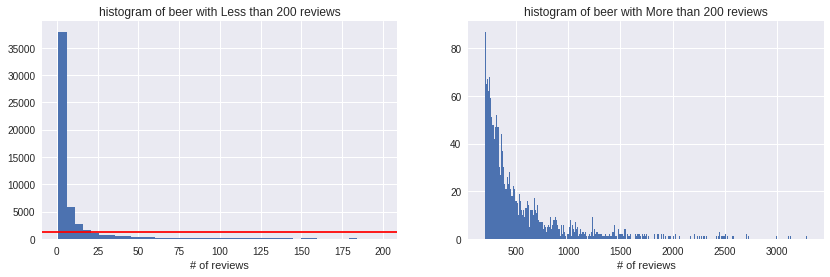

In [13]:
beer5more = freq_list_beer[np.where(freq_list_beer >= 200)]
beer5less = freq_list_beer[np.where(freq_list_beer < 200)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(beer5less, bins=40)
plt.title('histogram of beer with Less than 200 reviews')
plt.xlabel('# of reviews')
plt.axhline(y=1200, color='r', linestyle='-')

plt.subplot(122)
plt.hist(beer5more, bins=300)
plt.title('histogram of beer with More than 200 reviews')
plt.xlabel('# of reviews')

plt.show()

### 1.3 Subset from Metadata

In [14]:
# subset data for collabrotive filtering
df1 = df[['beer_name', 'beer_beerId', 'review_profileName', 'review_overall', 'review_time']]
print('Original data size: %s' % str(df1.shape)) 

# remove NA 
df1 = df1[pd.notnull(df1.beer_name) & pd.notnull(df1.review_profileName) & pd.notnull(df1.review_overall)]
# remove blanks
df1 = df1.loc[df1.review_profileName != '']
df1 = df1.loc[df1.beer_name != '']
df1 = df1.loc[df1.review_overall != '']
print('After removing NAs and blanks: %s' % str(df1.shape)) 

# drop duplicate (beer&user) pairs, keep the latest rating
df1['beer_user_pair'] = df1.beer_name + df1.review_profileName
df1 = df1.sort_values(by=['review_time'], ascending=False).drop_duplicates(subset=['beer_user_pair'])
print('After drop duplicate user-item pairs (only keep the latest rating), data size: %s' % str(df1.shape))

# convert review ratings to numberic
df1.review_overall = pd.to_numeric(df1.review_overall)

Original data size: (1586614, 5)
After removing NAs and blanks: (1586266, 5)
After drop duplicate user-item pairs (only keep the latest rating), data size: (1561405, 6)


In [15]:
df1.head(3)

,beer_name,beer_beerId,review_profileName,review_overall,review_time,beer_user_pair
581215,Pete's Wicked Strawberry Blonde,381,bk3nj,3.0,999999652,Pete's Wicked Strawberry Blondebk3nj
1023623,Fiji Bitter,1480,Mark,4.0,999980551,Fiji BitterMark
1077899,Wolaver's India Pale Ale,399,bcm119,3.5,999903142,Wolaver's India Pale Alebcm119


#### remove bottom users and beers

In [16]:
# subset three columns
cf = df1[['review_profileName', 'beer_name', 'review_overall']]

# sort user by # of reviews
cnt_user = dict(num_review_byuser)
cf['user_freq'] = [cnt_user.get(x) for x in cf.review_profileName]

# sort beer by # of reviews
cnt_beer = dict(num_review_bybeer)
cf['beer_freq'] = [cnt_beer.get(x) for x in cf.beer_name]

# drop users with less than 10 reviews
# drop beers with less than 5 reviews
cf = cf.loc[cf.user_freq > 10]
cf = cf.loc[cf.beer_freq > 5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
print('After removing bottom users and beers,')
print('%d unique beers;' % cf.beer_name.nunique())
print('%d unique users;' % cf.review_profileName.nunique())
print('and %d reviews in total.' % cf.shape[0])

After removing bottom users and beers,
18925 unique beers;
10189 unique users;
and 1423856 reviews in total.


In [18]:
cf.head(3)

,review_profileName,beer_name,review_overall,user_freq,beer_freq
581215,bk3nj,Pete's Wicked Strawberry Blonde,3.0,45,298
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257


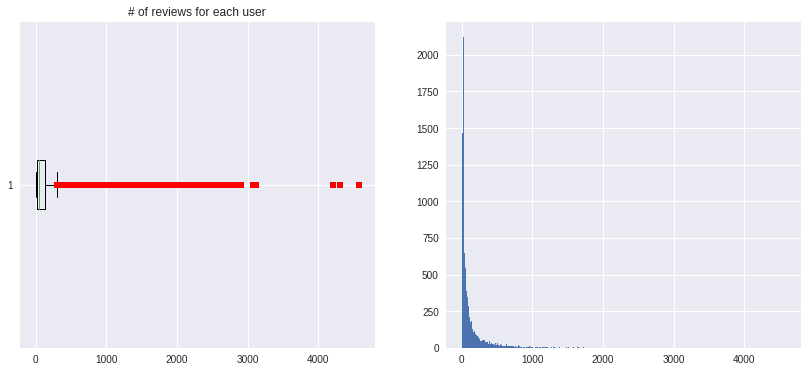

In [19]:
# user 
freq = cf.review_profileName.value_counts()
freq = np.array(list(dict(freq).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freq, 0, 'rs', 0)
plt.title('# of reviews for each user')

plt.subplot(122)
plt.hist(freq, bins=400)

plt.show()

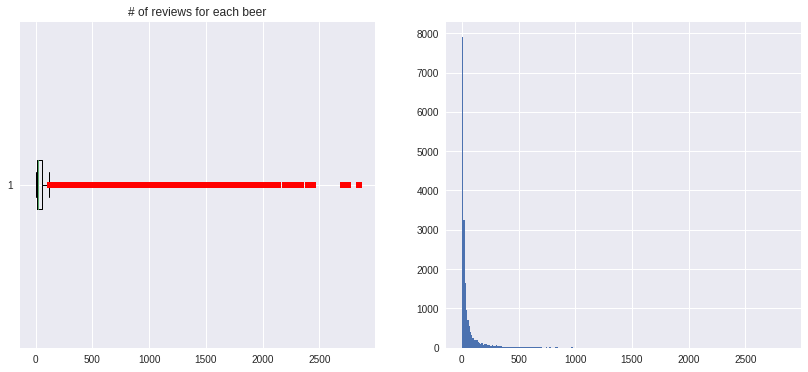

In [20]:
# beer
freqb = cf.beer_name.value_counts()
freqb = np.array(list(dict(freqb).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqb, 0, 'rs', 0)
plt.title('# of reviews for each beer')

plt.subplot(122)
plt.hist(freqb, bins=250)

plt.show()

#### split into two groups
- users with more than 100 reviews;
- users with less than 100 reviews.

In [21]:
# split into two groups
threshold = 100

more = cf.loc[cf.user_freq > threshold]
less = cf.loc[cf.user_freq <= threshold]

more.head()

,review_profileName,beer_name,review_overall,user_freq,beer_freq
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257
797362,Jason,Lindemans Framboise,3.5,2350,903
808675,Jason,Chapeau Framboise Lambic,4.0,2350,44
961766,Jason,Dooryard Ale,3.0,2350,13


group > 100 has the size: (1186781, 5)


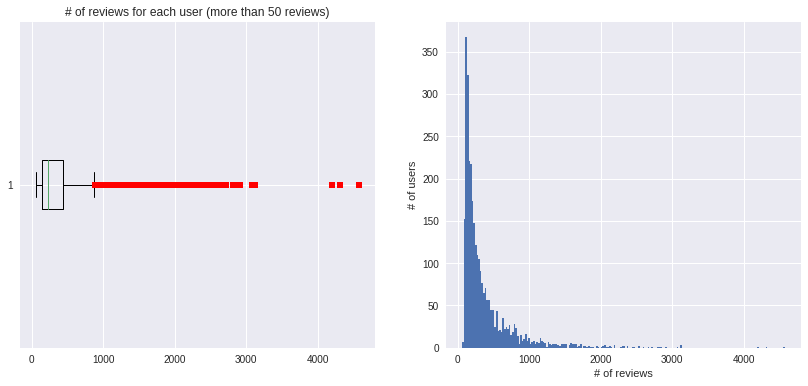

In [22]:
# visualize two groups
print('group > %d has the size: %s' % (threshold, str(more.shape)))

freqm = more.review_profileName.value_counts()
freqm = np.array(list(dict(freqm).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqm, 0, 'rs', 0)
plt.title('# of reviews for each user (more than 50 reviews)')

plt.subplot(122)
plt.hist(freqm, bins=200)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

group <= 100 has the size: (237075, 5)


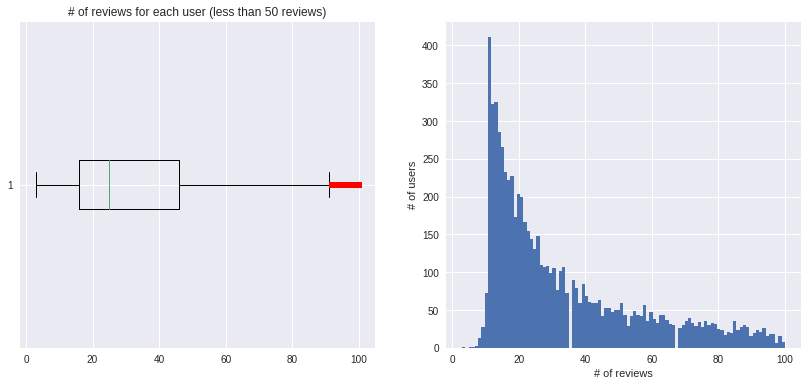

In [23]:
# visualize two groups
print('group <= %d has the size: %s' % (threshold, str(less.shape)))

freql = less.review_profileName.value_counts()
freql = np.array(list(dict(freql).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freql, 0, 'rs', 0)
plt.title('# of reviews for each user (less than 50 reviews)')

plt.subplot(122)
plt.hist(freql, bins=100)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

## Part 2: Prediction Models

In [0]:
# define functions to generate prediction dataframe
# borrowed from Surprise library
def get_Iu(uid):
    """Return the number of items rated by given user
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0
      
def get_pred_df(pred):
  pred_df = pd.DataFrame(pred, columns=['uid', 'iid', 'rui', 'est', 'details'])    
  pred_df['Iu'] = pred_df.uid.apply(get_Iu)
  pred_df['Ui'] = pred_df.iid.apply(get_Ui)
  pred_df['err'] = abs(pred_df.est - pred_df.rui)
  
  # append review counts
  pred_df['user_freq'] = [cnt_user.get(x) for x in pred_df.uid]
  pred_df = pred_df.sort_values(by=['uid'])
  
  return pred_df
  

### 2.1 SVD

In [25]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(cf[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset, testset = train_test_split(data, test_size=.33)

# fit
svd = SVD(n_factors = 30, lr_all = 0.01, reg_all = 0.05)
svd.fit(trainset)

# test 
svd_pred = svd.test(testset)
accuracy.rmse(svd_pred, verbose=True)

RMSE: 0.5905


0.5904706955421769

In [26]:
# predict
svd_pred_df = get_pred_df(svd_pred)
svd_pred_df.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
223267,0110x011,Brooklyn Local 1,4.5,4.180381,{'was_impossible': False},91,490,0.319619,139
26003,0110x011,Hoppe (Imperial Extra Pale Ale),3.0,4.189322,{'was_impossible': False},91,294,1.189322,139
302712,0110x011,Cable Car,4.0,4.705778,{'was_impossible': False},91,104,0.705778,139
340377,0110x011,Calabaza Blanca,4.5,4.172912,{'was_impossible': False},91,251,0.327088,139
321841,0110x011,Melange No. 1,5.0,4.355664,{'was_impossible': False},91,34,0.644336,139


### 2.2 Non-negative Matrix Factorization (NMF)

In [27]:
# fit
nmf = NMF(n_factors = 25, n_epochs = 50, reg_pu = 0.1, reg_qi = 0.1)
nmf.fit(trainset)

# test 
nmf_pred = nmf.test(testset)
accuracy.rmse(nmf_pred, verbose=True) 

RMSE: 0.5982


0.5981587554102197

In [28]:
# prediction
nmf_pred_df = get_pred_df(nmf_pred)
nmf_pred_df.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
223267,0110x011,Brooklyn Local 1,4.5,4.224069,{'was_impossible': False},91,490,0.275931,139
26003,0110x011,Hoppe (Imperial Extra Pale Ale),3.0,4.307013,{'was_impossible': False},91,294,1.307013,139
302712,0110x011,Cable Car,4.0,4.723434,{'was_impossible': False},91,104,0.723434,139
340377,0110x011,Calabaza Blanca,4.5,4.178317,{'was_impossible': False},91,251,0.321683,139
321841,0110x011,Melange No. 1,5.0,4.352681,{'was_impossible': False},91,34,0.647319,139


### 2.3 KNN user-based

##### set up model

In [0]:
# set up model
from surprise import KNNWithMeans

sim_options = {'name': 'pearson', 'user_based': True, 'min_support':10}  
knnmean1 = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)

knnmean2 = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)

#### 2.2.1 users with more than 100 reviews

In [30]:
# prepare train & test for KNN
reader = Reader(rating_scale=(1, 5))

knn_more = Dataset.load_from_df(more[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset_more, testset_more = train_test_split(knn_more, test_size=.33)

# fit
knnmean1.fit(trainset_more)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [0]:
# test
pred_more = knnmean1.test(testset_more)

In [32]:
# prediction
pred_more_df = get_pred_df(pred_more)
pred_more_df.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
156699,0110x011,La Folie,5.0,4.504072,"{'actual_k': 221, 'was_impossible': False}",91,483,0.495928,139
243795,0110x011,Brabant,3.5,4.117786,"{'actual_k': 102, 'was_impossible': False}",91,181,0.617786,139
193036,0110x011,IPA,4.0,4.201422,"{'actual_k': 240, 'was_impossible': False}",91,708,0.201422,139
77194,0110x011,Pure Hoppiness,5.0,4.752042,"{'actual_k': 186, 'was_impossible': False}",91,347,0.247958,139
62559,0110x011,Wachusett IPA (India Pale Ale),3.5,4.322178,"{'actual_k': 43, 'was_impossible': False}",91,92,0.822178,139


#### 2.2.2 users with less than 100 reviews

In [33]:
reader = Reader(rating_scale=(1, 5))

knn_less = Dataset.load_from_df(less[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset_less, testset_less = train_test_split(knn_less, test_size=.33)

# fit
knnmean2.fit(trainset_less)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [0]:
# test
pred_less = knnmean2.test(testset_less)

In [35]:
# predict
pred_less_df = get_pred_df(pred_less)
pred_less_df.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
38437,01121987,Écume,5.0,3.865289,"{'was_impossible': True, 'reason': 'User and/o...",21,11,1.134711,29
2732,01121987,Wernesgruner,5.0,4.277778,"{'actual_k': 0, 'was_impossible': False}",21,97,0.722222,29
16538,01121987,Sierra Nevada Summerfest Lager,5.0,4.277778,"{'actual_k': 0, 'was_impossible': False}",21,852,0.722222,29
61976,01121987,Don de Dieu,2.0,4.277778,"{'actual_k': 0, 'was_impossible': False}",21,725,2.277778,29
26402,01121987,König Pilsener,5.0,4.277778,"{'actual_k': 0, 'was_impossible': False}",21,146,0.722222,29


## Part 3: Summary

summarize rmse dict for three models

In [0]:
# get prediction error
svd_error = svd_pred_df[['uid', 'err', 'user_freq']].groupby('uid').mean()
nmf_error = nmf_pred_df[['uid', 'err', 'user_freq']].groupby('uid').mean()

knnmore_error = pred_more_df[['uid', 'err', 'user_freq']].groupby(['uid']).mean()
knnless_error = pred_less_df[['uid', 'err', 'user_freq']].groupby(['uid']).mean()
knn_error = pd.concat([knnmore_error, knnless_error])

# cut into bins
bins = [10, 20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
labels = ['11-20', '21-30', '31-40', '41-50', '51-100', '101-200', 
          '201-500', '501-1000', '1001-2000', '2001-6000']

svd_error['review_group'] = pd.cut(svd_error['user_freq'], bins = bins, labels = labels)
nmf_error['review_group'] = pd.cut(nmf_error['user_freq'], bins = bins, labels = labels)
knn_error['review_group'] = pd.cut(knn_error['user_freq'], bins = bins, labels = labels)

# get bins' rmse
svd_error = svd_error.groupby('review_group').mean().drop('user_freq',axis=1)
nmf_error = nmf_error.groupby('review_group').mean().drop('user_freq',axis=1)
knn_error = knn_error.groupby('review_group').mean().drop('user_freq',axis=1)

# rename
svd_error.columns = ['SVD']
nmf_error.columns = ['NMF']
knn_error.columns = ['KNN']

In [37]:
final = pd.concat([svd_error, nmf_error, knn_error], axis=1)
final

,SVD,NMF,KNN
review_group,,,
11-20,0.544777,0.562974,0.620522
21-30,0.517540,0.530912,0.584400
31-40,0.486797,0.497518,0.545737
41-50,0.491313,0.501406,0.548985
51-100,0.464687,0.473088,0.530519
101-200,0.447877,0.454506,0.460060
201-500,0.439610,0.446350,0.451105
501-1000,0.428859,0.434743,0.437470
1001-2000,0.445036,0.452086,0.458355


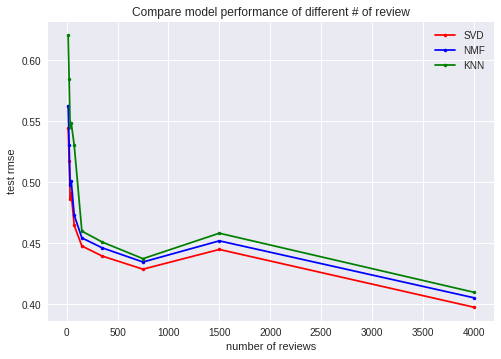

In [38]:
x = [15, 25, 35, 45, 75, 150, 350, 750, 1500, 4000]
y_svd = svd_error.values.tolist()
y_nmf = nmf_error.values.tolist()
y_knn = knn_error.values.tolist()

plt.plot(x, y_svd, '.r-') 
plt.plot(x, y_nmf, '.b-') 
plt.plot(x, y_knn, '.g-') 
plt.xlabel('number of reviews')
plt.ylabel('test rmse')
plt.title('Compare model performance of different # of review')
plt.legend(('SVD', 'NMF', 'KNN'), loc='upper right')
plt.show()